<a href="https://colab.research.google.com/github/Otobi1/Back-to-Basics-A-Refresher-/blob/master/Back_to_Basics_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
# Embeddings 
# - these are capable of capturing the contextual, semantic and syntatic meaning in data.

# While one-hot encoding allows us to preserve the structural info, it has two disadvantages 
# 1. linearly dependent on the number of unique token in the vocab which is problem if we have a large corpus
# 2. the representation for each token does not preserve any relationship with respect to other tokens

# Embeddings address the short comings of one-hot encoding
# - its main idea is to have fixed length representations for the tokens in a text regardless of the tokens in the vocab
# with one-hot encoding, each token is represented by an array of size vocab size but with embeddings, each token now has the shape embed dim
###- the values in the rep are not fixed binary values but rather changing floating points allowing for fine-grained learned reps

# the objective here is to rep tokens in text that capture the intrinsic semantic relationships
## leveraging the low-dimensionality while capturing relationships and interpretable token reps.

In [55]:
# Learning Embeddings 
# - We can learn embeddings by creating our model in PyTorch, but first, we're going to use a library that specialises in embeddings and topic modelling called Gensim

import nltk
nltk.download('punkt');
import numpy as np
import re
import urllib

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [56]:
SEED = 1234

In [57]:
# Set seed for reproducibility 

np.random.seed(SEED)

In [58]:
# Split text into sentences 

tokeniser = nltk.data.load("tokenizers/punkt/english.pickle")
book = urllib.request.urlopen(url = "https://raw.githubusercontent.com/GokuMohandas/madewithml/main/datasets/harrypotter.txt")
sentences = tokeniser.tokenize(str(book.read()))
print (f"{len(sentences)} sentences")

12443 sentences


In [59]:
def preprocess(text):
  """Conditional preprocessing on our text."""
  # Lower
  text = text.lower()

  # Spacing and filters 
  text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
  text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric characters 
  text = re.sub(' +', ' ', text) # remove multiple spaces
  text = text.strip()

  # Separate into word tokens
  text = text.split(" ")

  return text

In [60]:
# Preprocess sentences
print (sentences[11])
sentences = [preprocess(sentence) for sentence in sentences]
print (sentences[11])

Snape nodded, but did not elaborate.
['snape', 'nodded', 'but', 'did', 'not', 'elaborate']


In [61]:
# How doe we learn the embeddings in the first place?
# The intuition behind embeddins is that the definition of a token depends NOT on the token itself, but on its context.
# - There are several ways of doing this. 
# -- given the word in context, predict the target word (CBOW - continous bag of words)
# -- given the target word, predict the context word (skip-gram)
# -- given a sequence of words, predict the next word(LM - language modelling)

# all these approaches involve the creation of data to train the model on. 
# Every word in a sentence becomes the target word and the context words are determined by a window
# we repeat this for every sentence in the corpus and this results in the training data for unsupervised taskk

# the idea is that similar target words will appear with similar contexts and we can learn this relationship by repeatedly training our model (wiht context and target) pairs

In [62]:
# Word2Vec

# working with large vocabs to learn embeddings can become complicated quickly
# Here, we can use the "negative sampling", which only updates the correct class and a few arbitrary incorrect classes 
# We can do this because of the large amoutn of training data where we will see the same word as the target class multiple times

import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

In [63]:
EMBEDDING_DIM = 100
WINDOW = 5
MIN_COUNT = 3 # ignores all the words with total frequency lower than this
SKIP_GRAM = 1 # 0 = CBOW
NEGATIVE_SAMPLING = 20

In [64]:
# super fast because of optimised C code under the hood

w2v = Word2Vec(sentences = sentences, size = EMBEDDING_DIM, window = WINDOW,
               min_count = MIN_COUNT, sg = SKIP_GRAM, negative = NEGATIVE_SAMPLING)
print (w2v)

Word2Vec(vocab=4937, size=100, alpha=0.025)


In [65]:
# Vector for each word
w2v.wv.get_vector("potter")

array([ 0.01697466, -0.2866405 , -0.3008265 , -0.29403865, -0.22781292,
       -0.19741872, -0.0874659 ,  0.14124094,  0.58748853,  0.33553848,
       -0.240756  , -0.04006175, -0.13412021,  0.17894153, -0.14883168,
       -0.34405807,  0.27631482,  0.26866025, -0.5066555 ,  0.14108138,
       -0.13761571, -0.3687644 , -0.06418797,  0.18793695, -0.2570797 ,
        0.35075605,  0.13261083,  0.17419575, -0.05647279, -0.07211813,
        0.59689295,  0.55984116, -0.01833745, -0.45927507, -0.34138373,
       -0.0491113 ,  0.37332585, -0.3035386 , -0.4004415 , -0.06110671,
       -0.00195717, -0.10445888, -0.28035152, -0.16219528,  0.2807279 ,
        0.41262493,  0.0014628 , -0.35501745,  0.22529054, -0.25333297,
        0.11366666,  0.25780088,  0.03564634,  0.04202371,  0.02636017,
        0.04561004,  0.42189986,  0.01397108,  0.2692497 , -0.26579332,
       -0.0788378 , -0.10421843, -0.23964319,  0.12406243,  0.17855582,
        0.21702808, -0.31919608,  0.46681818, -0.22580583, -0.14

In [66]:
# Get nearest neighbours (excluding itself)

w2v.wv.most_similar(positive = "scar", topn = 5)

[('forehead', 0.9274433255195618),
 ('pain', 0.9227378368377686),
 ('mouth', 0.9116102457046509),
 ('prickling', 0.9068350195884705),
 ('heart', 0.8966714143753052)]

In [67]:
# Saving and loading 

w2v.wv.save_word2vec_format("model.bin", binary = True)
w2v = KeyedVectors.load_word2vec_format("model.bin", binary = True)

In [68]:
# FastText

# What happens if a word doesnt exist in the vocab?
# We could assign an "UNK" (unkown) token which is used for all OOV (out of vocab) words or we could use FastText, which uses character-level n-grams to embed a word
# This helps embed rare words, misspelled words and also words that don't exist in our corpus but are similar to words in our corpus

In [69]:
from gensim.models import FastText

In [70]:
# super fast because of the optimised C code under the hood

ft = FastText(sentences = sentences, size = EMBEDDING_DIM, window = WINDOW, 
              min_count = MIN_COUNT, sg = SKIP_GRAM, negative = NEGATIVE_SAMPLING)
print (ft)

FastText(vocab=4937, size=100, alpha=0.025)


In [71]:
# This word doesn't 'exist so the word2vec model will error out 

# w2v.wv.most_similar(positive = "scarring", topn = 5) # uncomment to check

In [72]:
# FastText on the other hand will use n-grams to embed an OOV word

ft.wv.most_similar(positive = "scarring", topn = 10)

[('prickling', 0.9862031936645508),
 ('shuddering', 0.982107937335968),
 ('heartstring', 0.9814382791519165),
 ('brandishing', 0.9805978536605835),
 ('rippling', 0.9801949858665466),
 ('muffling', 0.980065107345581),
 ('shimmering', 0.9799435138702393),
 ('crumbling', 0.9794167280197144),
 ('shivering', 0.9788283109664917),
 ('compressing', 0.9781619310379028)]

In [73]:
# Save and load 

ft.wv.save("model.bin")
ft = KeyedVectors.load("model.bin")

In [74]:
# Pretrained embeddings

# - we can learn embeddings from scratch as above but we can also leverage pretrained embeddings that have been trained on millions of docs. 
# Popular ones include Word2Vec (skip gram) or GloVe(global word word co-occurence)
# we can validate that these embeddings captured meaningful semantic relationships by confirming them 

from gensim.scripts.glove2word2vec import glove2word2vec
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from urllib.request import urlopen
from zipfile import ZipFile

In [94]:
# Arguments 

EMBEDDING_DIM = 100

In [95]:
def plot_embeddings(words, embeddings, pca_results):
  for word in words:
    index = embeddings.index2word.index(word)
    plt.scatter(pca_results[index, 0], pca_results[index, 1])
    plt.annotate(word, xy = (pca_results[index, 0], pca_results[index, 1]))
  plt.show()

In [96]:
# Unzip the file (may a while)

resp = urlopen("http://nlp.stanford.edu/data/glove.6B.zip")
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.namelist()

['glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt']

In [97]:
# Write embeddings to file 

embeddings_file = "glove.6B.{0}d.txt".format(EMBEDDING_DIM)
zipfile.extract(embeddings_file)

'/content/glove.6B.100d.txt'

In [98]:
# Preview of the GloVe embeddings file 

with open(embeddings_file, "r") as fp:
  line = next(fp)
  values = line.split()
  word = values[0]
  embedding = np.asarray(values[1:], dtype = "float32")
  print (f"word: {word}")
  print (f"embedding:\n{embedding}")
  print (f"embedding dim: {len(embedding)}")

word: the
embedding:
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459


In [99]:
# Save GloVe embeddings to local directory in word2vec format

word2vec_output_file = "{0}.word2vec".format(embeddings_file)
glove2word2vec(embeddings_file, word2vec_output_file)

(400000, 100)

In [100]:
# Load embeddings (may take a while)

glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary = False)

In [101]:
# (king - man) + woman = ?

glove.most_similar(positive = ["woman", "king"], negative = ["man"], topn = 5)

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755735874176025),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534753799438)]

In [102]:
# Get nearest neighbours (excluding itself)

glove.wv.most_similar(positive = "goku", topn = 5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('gohan', 0.7246542572975159),
 ('bulma', 0.6497020125389099),
 ('raistlin', 0.6443604230880737),
 ('skaar', 0.6316742897033691),
 ('guybrush', 0.6231324672698975)]

In [103]:
# Reduce dimensionality for plotting

X = glove[glove.wv.vocab]
pca = PCA(n_components = 2)
pca_results = pca.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


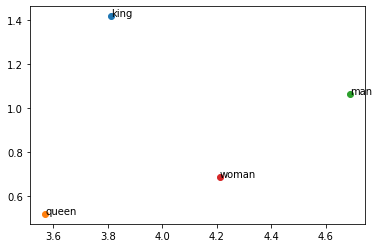

In [105]:
# Visualise 

plot_embeddings(words = ["king", "queen", "man", "woman"], 
                embeddings = glove, pca_results = pca_results)

In [106]:
# Bias in embeddings 

glove.most_similar(positive = ["woman", "doctor"], negative = ["man"], topn = 5)

[('nurse', 0.7735227346420288),
 ('physician', 0.7189429998397827),
 ('doctors', 0.6824328303337097),
 ('patient', 0.6750682592391968),
 ('dentist', 0.6726033687591553)]

In [107]:
# Set up

import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn

In [108]:
SEED = 1234

In [109]:
def set_seeds(seed = 1234):
  """Set seeds for reproducibility."""
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed) # multi GPU

In [110]:
# Set seeds for reproducibility 

set_seeds(seed = SEED)

In [111]:
# Set device

cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
  torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

cpu


In [112]:
# Load data

url = "https://raw.githubusercontent.com/GokuMohandas/madewithml/main/datasets/news.csv"
df = pd.read_csv(url, header = 0) # load
df = df.sample(frac = 1).reset_index(drop = True) #shuffle
df.head()

,title,category
0,Sharon Accepts Plan to Reduce Gaza Army Operat...,World
1,Internet Key Battleground in Wildlife Crime Fight,Sci/Tech
2,July Durable Good Orders Rise 1.7 Percent,Business
3,Growing Signs of a Slowing on Wall Street,Business
4,The New Faces of Reality TV,World


In [113]:
# Preprocessing 

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [114]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
print (STOPWORDS[:5])
porter = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we']


In [115]:
def preprocess(text, stopwords = STOPWORDS):
  """Conditional preprocessing on our text unique to our task."""

  # Lower
  text = text.lower()

  # Remove stopwords
  pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
  text = pattern.sub('', text)

  # Remove words in parenthesis
  text = re.sub(r'\([^)]*\)', '', text)

  # Spacing and filters 
  text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
  text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric chars
  text = re.sub(' +', ' ', text) # remove multiple spaces
  text = text.strip()

  return text

In [116]:
# Sample 
text = "Greet week for the NYSE!"
preprocess(text = text)

'greet week nyse'

In [117]:
# Apply dataframe

preprocessed_df = df.copy()
preprocessed_df.title = preprocessed_df.title.apply(preprocess)
print (f"{df.title.values[0]}\n\n{preprocessed_df.title.values[0]}")

Sharon Accepts Plan to Reduce Gaza Army Operation, Haaretz Says

sharon accepts plan reduce gaza army operation haaretz says


In [118]:
# Split data 

import collections
from sklearn.model_selection import train_test_split

In [119]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [120]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [121]:
# Data
X = preprocessed_df["title"].values
y = preprocessed_df["category"].values

In [122]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (84000,), y_train: (84000,)
X_val: (18000,), y_val: (18000,)
X_test: (18000,), y_test: (18000,)
Sample point: china battles north korea nuclear talks → World


In [123]:
# Label encoding 

import itertools

In [124]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y_train)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [126]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
NUM_CLASSES = len(label_encoder)
label_encoder.class_to_index

{'Business': 0, 'Sci/Tech': 1, 'Sports': 2, 'World': 3}

In [127]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: World
y_train[0]: 3


In [128]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [21000 21000 21000 21000]
weights: {0: 4.761904761904762e-05, 1: 4.761904761904762e-05, 2: 4.761904761904762e-05, 3: 4.761904761904762e-05}


In [129]:
# Tokeniser 

import json
from collections import Counter
from more_itertools import take

In [130]:
class Tokeniser(object):
    def __init__(self, char_level, num_tokens=None,
                 pad_token='<PAD>', oov_token='<UNK>',
                 token_to_index=None):
        self.char_level = char_level
        self.separator = '' if self.char_level else ' '
        if num_tokens: num_tokens -= 2 # pad + unk tokens
        self.num_tokens = num_tokens
        self.oov_token = oov_token
        if not token_to_index:
            token_to_index = {'<PAD>': 0, '<UNK>': 1}
        self.token_to_index = token_to_index
        self.index_to_token = {v: k for k, v in self.token_to_index.items()}

    def __len__(self):
        return len(self.token_to_index)

    def __str__(self):
        return f"<Tokeniser(num_tokens={len(self)})>"

    def fit_on_texts(self, texts):
        if self.char_level:
            all_tokens = [token for text in texts for token in text]
        if not self.char_level:
            all_tokens = [token for text in texts for token in text.split(' ')]
        counts = Counter(all_tokens).most_common(self.num_tokens)
        self.min_token_freq = counts[-1][1]
        for token, count in counts:
            index = len(self)
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return self

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            if not self.char_level:
                text = text.split(' ')
            sequence = []
            for token in text:
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]))
            sequences.append(np.asarray(sequence))
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(index, self.oov_token))
            texts.append(self.separator.join([token for token in text]))
        return texts

    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {
                'char_level': self.char_level,
                'oov_token': self.oov_token,
                'token_to_index': self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [131]:
# Tokenise
tokeniser = Tokeniser(char_level=False, num_tokens=5000)
tokeniser.fit_on_texts(texts=X_train)
VOCAB_SIZE = len(tokeniser)
print (tokeniser)

<Tokeniser(num_tokens=5000)>


In [132]:
# Sample of tokens

print (take(5, tokeniser.token_to_index.items()))
print (f"least freq token's freq: {tokeniser.min_token_freq}") # use this to adjust num_tokens

[('<PAD>', 0), ('<UNK>', 1), ('39', 2), ('b', 3), ('gt', 4)]
least freq token's freq: 14


In [133]:
# Convert texts to sequences of indices

X_train = tokeniser.texts_to_sequences(X_train)
X_val = tokeniser.texts_to_sequences(X_val)
X_test = tokeniser.texts_to_sequences(X_test)
preprocessed_text = tokeniser.sequences_to_texts([X_train[0]])[0]
print ("Text to indices:\n"
    f"  (preprocessed) → {preprocessed_text}\n"
    f"  (tokenized) → {X_train[0]}")

Text to indices:
  (preprocessed) → china battles north korea nuclear talks
  (tokenized) → [  16 1491  285  142  114   24]


In [134]:
# Embedding layer 

# Inputs 

vocab_size = 10
x = torch.randint(high = vocab_size, size = (1, 5))
print (x)
print (x.shape)

tensor([[5, 1, 6, 5, 6]])
torch.Size([1, 5])


In [135]:
# Embedding layer 

embeddings = nn.Embedding(embedding_dim = 100, num_embeddings = vocab_size)
print (embeddings.weight.shape)

torch.Size([10, 100])


In [136]:
# Embed the input

embeddings(x).shape

torch.Size([1, 5, 100])

In [137]:
# Padding 

def pad_sequences(sequences, max_seq_len=0):
    """Pad sequences to max length in sequence."""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    padded_sequences = np.zeros((len(sequences), max_seq_len))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

In [138]:
# 2D sequences
padded = pad_sequences(X_train[0:3])
print (padded.shape)
print (padded)

(3, 6)
[[1.600e+01 1.491e+03 2.850e+02 1.420e+02 1.140e+02 2.400e+01]
 [1.445e+03 2.300e+01 6.560e+02 2.197e+03 1.000e+00 0.000e+00]
 [1.200e+02 1.400e+01 1.955e+03 1.005e+03 1.529e+03 4.014e+03]]


In [139]:
FILTER_SIZES = list(range(1, 4)) # uni, bi and tri grams

In [140]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, max_filter_size):
        self.X = X
        self.y = y
        self.max_filter_size = max_filter_size

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, y]

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        X = np.array(batch, dtype=object)[:, 0]
        y = np.stack(np.array(batch, dtype=object)[:, 1], axis=0)

        # Pad sequences
        X = pad_sequences(X)

        # Cast
        X = torch.LongTensor(X.astype(np.int32))
        y = torch.LongTensor(y.astype(np.int32))

        return X, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle, drop_last=drop_last, pin_memory=True)

In [141]:
# Create datasets
max_filter_size = max(FILTER_SIZES)
train_dataset = Dataset(X=X_train, y=y_train, max_filter_size=max_filter_size)
val_dataset = Dataset(X=X_val, y=y_val, max_filter_size=max_filter_size)
test_dataset = Dataset(X=X_test, y=y_test, max_filter_size=max_filter_size)
print ("Datasets:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  X: {train_dataset[0][0]}\n"
    f"  y: {train_dataset[0][1]}")

Datasets:
  Train dataset:<Dataset(N=84000)>
  Val dataset: <Dataset(N=18000)>
  Test dataset: <Dataset(N=18000)>
Sample point:
  X: [  16 1491  285  142  114   24]
  y: 3


In [142]:
# Create dataloaders
batch_size = 64
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)
batch_X, batch_y = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n"
    "Sample point:\n"
    f"  X: {batch_X[0]}\n"
    f"  y: {batch_y[0]}")

Sample batch:
  X: [64, 14]
  y: [64]
Sample point:
  X: tensor([  16, 1491,  285,  142,  114,   24,    0,    0,    0,    0,    0,    0,
           0,    0])
  y: 3


In [143]:
# Model 

import math
import torch.nn.functional as F

In [144]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
DROPOUT_P = 0.1

In [145]:
class CNN(nn.Module):
  def __init__(self, embedding_dim, vocab_size, num_filters, 
               filter_sizes, hidden_dim, dropout_p, num_classes, 
               pretrained_embeddings = None, freeze_embeddings = False, 
               padding_idx = 0):
    super(CNN, self).__init__()

    # Filter sizes 
    self.filter_sizes = filter_sizes

    # Initialise embeddings 
    if pretrained_embeddings is None:
      self.embeddings = nn.Embedding(embedding_dim = embedding_dim, 
                                     num_embeddings = vocab_size, padding_idx = padding_idx)
    else:
      pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
      self.embeddings = nn.Embedding(embedding_dim = embedding_dim,
                                     num_embeddings = vocab_size, padding_idx = padding_idx, _weight = pretrained_embeddings)
    
    # Freeze embeddings or not
    if freeze_embeddings:
      self.embeddings.weight.requires_grad = False

    # Conv weights
    self.conv = nn.ModuleList([nn.Conv1d(in_channels = embedding_dim, 
                                         out_channels = num_filters, kernel_size = f) for f in filter_sizes])
    
    # Fully Connected weights 
    self.dropout = nn.Dropout(dropout_p)
    self.fc1 = nn.Linear(num_filters * len(filter_sizes), hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, num_classes)
  
  def forward(self, inputs, channel_first = False, apply_softmax = False):

    # Embed
    x_in, = inputs
    x_in = self.embeddings(x_in)

    # Rearrange input so num_channels is in dim 1 (N, C, L)
    if not channel_first:
      x_in = x_in.transpose(1, 2)

    # Conv outputs 
    z = []
    max_seq_len = x_in.shape[2]
    for i, f in enumerate(self.filter_sizes):
      # SAME padding
      padding_left = int((self.conv[i].stride[0] * (max_seq_len-1) - max_seq_len + self.filter_sizes[i]) / 2)
      padding_right = int(math.ceil((self.conv[i].stride[0] * (max_seq_len -1) - max_seq_len + self.filter_sizes[i]) / 2))

      # Conv + pool
      _z = self.conv[i](F.pad(x_in, (padding_left, padding_right)))
      _z = F.max_pool1d(_z, _z.size(2)).squeeze(2)
      z.append(_z)

    # Concat conv outputs
    z = torch.cat(z, 1)

    # FC layers 
    z = self.fc1(z)
    z = self.dropout(z)
    y_pred = self.fc2(z)

    if apply_softmax:
      y_pred = F.softmax(y_pred, dim = 1)
    return y_pred

In [146]:
# Using GloVe

# here, we will create some utility functions to load the pretrained GloVe embeddings into the embedding layer 

def load_glove_embeddings(embeddings_file):
  """Load embeddings from a file."""
  embeddings = {}
  with open(embeddings_file, "r") as fp:
    for index, line in enumerate(fp):
      values = line.split()
      word = values[0]
      embedding = np.asarray(values[1:], dtype = "float32")
      embeddings[word] = embedding
  return embeddings

In [147]:
def make_embeddings_matrix(embeddings, word_index, embedding_dim):
  """Create embeddings matrix to use in Embedding layer."""
  embedding_matrix = np.zeros((len(word_index), embedding_dim))
  for word, i in word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
  return embedding_matrix

In [148]:
# Create embeddings 

embeddings_file = "glove.6B.{0}d.txt".format(EMBEDDING_DIM)
glove_embeddings = load_glove_embeddings(embeddings_file = embeddings_file)
embedding_matrix = make_embeddings_matrix(embeddings = glove_embeddings, word_index = tokeniser.token_to_index, 
                                          embedding_dim = EMBEDDING_DIM)
print (f"<Embeddings(words = {embedding_matrix.shape[0]}, dim = {embedding_matrix.shape[1]})>")

<Embeddings(words = 5000, dim = 100)>


In [149]:
# Experiments

import json
from sklearn.metrics import precision_recall_fscore_support
from torch.optim import Adam


In [150]:
NUM_FILTERS = 50
LEARNING_RATE = 1e-3
PATIENCE = 5
NUM_EPOCHS = 10

In [172]:
class Trainer(object):
    def __init__(self, model, device, loss = None, optimiser = None, scheduler = None):

        # Set params
        self.model = model
        self.device = device
        self.loss = loss
        self.optimiser = optimiser
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0

        # Iterate over train batches
        for i, batch in enumerate(dataloader):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, targets = batch[:-1], batch[-1]
            self.optimiser.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimiser.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)

        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)

                # Store outputs
                y_prob = torch.sigmoid(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.no_grad():
            for i, batch in enumerate(dataloader):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                y_prob = self.model(inputs, apply_softmax=True)

                # Store outputs
                y_probs.extend(y_prob)

        return np.vstack(y_probs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            # Steps
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            # Logging
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}, "
                f"lr: {self.optimiser.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model

In [173]:
def get_performance(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Get metrics
    performance = {'overall': {}, 'class': {}}
    metrics = precision_recall_fscore_support(y_true, y_pred)

    # Overall performance
    performance['overall']['precision'] = np.mean(metrics[0])
    performance['overall']['recall'] = np.mean(metrics[1])
    performance['overall']['f1'] = np.mean(metrics[2])
    performance['overall']['num_samples'] = np.float64(np.sum(metrics[3]))

    # Per-class performance
    for i in range(len(classes)):
        performance['class'][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i])
        }

    return performance

In [174]:
PRETRAINED_EMBEDDINGS = None
FREEZE_EMBEDDINGS = False

In [175]:
# Initialise model 

model = CNN(embedding_dim = EMBEDDING_DIM, vocab_size = VOCAB_SIZE, 
            num_filters = NUM_FILTERS, filter_sizes = FILTER_SIZES, 
            hidden_dim = HIDDEN_DIM, dropout_p = DROPOUT_P, num_classes = NUM_CLASSES, 
            pretrained_embeddings = PRETRAINED_EMBEDDINGS, freeze_embeddings = FREEZE_EMBEDDINGS)
model = model.to(device) # set device

print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [176]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [177]:
# Define optimizer & scheduler
optimiser = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser, mode='min', factor=0.1, patience=3)

In [178]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss=loss,
    optimiser=optimiser, scheduler=scheduler)

In [179]:
# Train
best_model = trainer.train(
    NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader)

Epoch: 1 | train_loss: 0.76718, val_loss: 0.58872, lr: 1.00E-03, _patience: 5
Epoch: 2 | train_loss: 0.49107, val_loss: 0.55072, lr: 1.00E-03, _patience: 5
Epoch: 3 | train_loss: 0.40240, val_loss: 0.56294, lr: 1.00E-03, _patience: 4
Epoch: 4 | train_loss: 0.34255, val_loss: 0.60096, lr: 1.00E-03, _patience: 3
Epoch: 5 | train_loss: 0.29370, val_loss: 0.66315, lr: 1.00E-03, _patience: 2
Epoch: 6 | train_loss: 0.25373, val_loss: 0.72333, lr: 1.00E-04, _patience: 1
Stopping early!


In [180]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

In [181]:
# Determine performance
performance = get_performance(
    y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance['overall'], indent=2))

{
  "precision": 0.8101679112036401,
  "recall": 0.8088333333333333,
  "f1": 0.809253011881923,
  "num_samples": 18000.0
}


In [182]:
# GloVe (frozen)
PRETRAINED_EMBEDDINGS = embedding_matrix
FREEZE_EMBEDDINGS = True


In [183]:
# Initialize model
model = CNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE,
    num_filters=NUM_FILTERS, filter_sizes=FILTER_SIZES,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES,
    pretrained_embeddings=PRETRAINED_EMBEDDINGS, freeze_embeddings=FREEZE_EMBEDDINGS)
model = model.to(device) # set device
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [184]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [186]:
# Define optimizer & scheduler
optimiser = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser, mode='min', factor=0.1, patience=3)

In [188]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss=loss,
    optimiser=optimiser, scheduler=scheduler)

In [189]:
# Train
best_model = trainer.train(
    NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader)

Epoch: 1 | train_loss: 0.51623, val_loss: 0.47505, lr: 1.00E-03, _patience: 5
Epoch: 2 | train_loss: 0.44337, val_loss: 0.46294, lr: 1.00E-03, _patience: 5
Epoch: 3 | train_loss: 0.41203, val_loss: 0.46383, lr: 1.00E-03, _patience: 4
Epoch: 4 | train_loss: 0.38774, val_loss: 0.46976, lr: 1.00E-03, _patience: 3
Epoch: 5 | train_loss: 0.36891, val_loss: 0.48075, lr: 1.00E-03, _patience: 2
Epoch: 6 | train_loss: 0.35252, val_loss: 0.49133, lr: 1.00E-04, _patience: 1
Stopping early!


In [190]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

In [191]:
# Determine performance
performance = get_performance(
    y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance['overall'], indent=2))

{
  "precision": 0.8329081942245948,
  "recall": 0.8323888888888888,
  "f1": 0.832367757305705,
  "num_samples": 18000.0
}


In [192]:
# GloVE (fine tuned)
PRETRAINED_EMBEDDINGS = embedding_matrix
FREEZE_EMBEDDINGS = False

In [193]:
# Initialize model
model = CNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE,
    num_filters=NUM_FILTERS, filter_sizes=FILTER_SIZES,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES,
    pretrained_embeddings=PRETRAINED_EMBEDDINGS, freeze_embeddings=FREEZE_EMBEDDINGS)
model = model.to(device) # set device
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [194]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [196]:
# Define optimiser & scheduler
optimiser = Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser, mode='min', factor=0.1, patience=3)

In [198]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss=loss,
    optimiser=optimiser, scheduler=scheduler)

In [199]:
# Train
best_model = trainer.train(
    NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader)

Epoch: 1 | train_loss: 0.48926, val_loss: 0.44469, lr: 1.00E-03, _patience: 5
Epoch: 2 | train_loss: 0.39026, val_loss: 0.44103, lr: 1.00E-03, _patience: 5
Epoch: 3 | train_loss: 0.34401, val_loss: 0.45837, lr: 1.00E-03, _patience: 4
Epoch: 4 | train_loss: 0.29974, val_loss: 0.49504, lr: 1.00E-03, _patience: 3
Epoch: 5 | train_loss: 0.25475, val_loss: 0.55088, lr: 1.00E-03, _patience: 2
Epoch: 6 | train_loss: 0.21122, val_loss: 0.63680, lr: 1.00E-04, _patience: 1
Stopping early!


In [200]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

In [201]:
# Determine performance
performance = get_performance(
    y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance['overall'], indent=2))

{
  "precision": 0.8305410534205683,
  "recall": 0.8301666666666666,
  "f1": 0.8302706249646987,
  "num_samples": 18000.0
}


In [203]:
# Save artifacts
from pathlib import Path
dir = Path("cnn")
dir.mkdir(parents=True, exist_ok=True)
label_encoder.save(fp=Path(dir, 'label_encoder.json'))
tokeniser.save(fp=Path(dir, 'tokeniser.json'))
torch.save(best_model.state_dict(), Path(dir, 'model.pt'))
with open(Path(dir, 'performance.json'), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

In [204]:
# inference 

def get_probability_distribution(y_prob, classes):
    """Create a dict of class probabilities from an array."""
    results = {}
    for i, class_ in enumerate(classes):
        results[class_] = np.float64(y_prob[i])
    sorted_results = {k: v for k, v in sorted(
        results.items(), key=lambda item: item[1], reverse=True)}
    return sorted_results

In [206]:
# Load artifacts
device = torch.device("cpu")
label_encoder = LabelEncoder.load(fp=Path(dir, 'label_encoder.json'))
tokeniser = Tokeniser.load(fp=Path(dir, 'tokeniser.json'))
model = CNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE,
    num_filters=NUM_FILTERS, filter_sizes=FILTER_SIZES,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES,
    pretrained_embeddings=PRETRAINED_EMBEDDINGS, freeze_embeddings=FREEZE_EMBEDDINGS)
model.load_state_dict(torch.load(Path(dir, 'model.pt'), map_location=device))
model.to(device)

CNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

In [207]:
# Initialize trainer
trainer = Trainer(model=model, device=device)

In [209]:
# Dataloader
text = "The final tennis tournament starts next week."
X = tokeniser.texts_to_sequences([preprocess(text)])
print (tokeniser.sequences_to_texts(X))
y_filler = label_encoder.encode([label_encoder.classes[0]]*len(X))
dataset = Dataset(X=X, y=y_filler, max_filter_size=max_filter_size)
dataloader = dataset.create_dataloader(batch_size=batch_size)

['final tennis tournament starts next week']


In [210]:
# Inference
y_prob = trainer.predict_step(dataloader)
y_pred = np.argmax(y_prob, axis=1)
label_encoder.decode(y_pred)

['Sports']

In [211]:
# Class distributions
prob_dist = get_probability_distribution(y_prob=y_prob[0], classes=label_encoder.classes)
print (json.dumps(prob_dist, indent=2))

{
  "Sports": 0.9999998807907104,
  "World": 1.7412990871434886e-07,
  "Sci/Tech": 8.365978132474083e-09,
  "Business": 6.17230710986405e-10
}


In [212]:
# Interpretability 

import collections
import seaborn as sns

In [213]:
class InterpretableCNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, num_filters,
                 filter_sizes, hidden_dim, dropout_p, num_classes,
                 pretrained_embeddings=None, freeze_embeddings=False,
                 padding_idx=0):
        super(InterpretableCNN, self).__init__()

        # Filter sizes
        self.filter_sizes = filter_sizes

        # Initialize embeddings
        if pretrained_embeddings is None:
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx, _weight=pretrained_embeddings)

        # Freeze embeddings or not
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False

        # Conv weights
        self.conv = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim,
                       out_channels=num_filters,
                       kernel_size=f) for f in filter_sizes])

        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_filters*len(filter_sizes), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs, channel_first=False, apply_softmax=False):

        # Embed
        x_in, = inputs
        x_in = self.embeddings(x_in)

        # Rearrange input so num_channels is in dim 1 (N, C, L)
        if not channel_first:
            x_in = x_in.transpose(1, 2)

        # Conv outputs
        z = []
        max_seq_len = x_in.shape[2]
        for i, f in enumerate(self.filter_sizes):
            # `SAME` padding
            padding_left = int((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2)
            padding_right = int(math.ceil((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2))

            # Conv + pool
            _z = self.conv[i](F.pad(x_in, (padding_left, padding_right)))
            z.append(_z.cpu().numpy())

        return z

In [214]:
PRETRAINED_EMBEDDINGS = embedding_matrix
FREEZE_EMBEDDINGS = False

In [215]:
# Initialize model
interpretable_model = InterpretableCNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE,
    num_filters=NUM_FILTERS, filter_sizes=FILTER_SIZES,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES,
    pretrained_embeddings=PRETRAINED_EMBEDDINGS, freeze_embeddings=FREEZE_EMBEDDINGS)
interpretable_model.load_state_dict(torch.load(Path(dir, 'model.pt'), map_location=device))
interpretable_model.to(device)

InterpretableCNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

In [216]:
# Initialize trainer
interpretable_trainer = Trainer(model=interpretable_model, device=device)

In [217]:
# Get conv outputs
conv_outputs = interpretable_trainer.predict_step(dataloader)
print (conv_outputs.shape) # (len(filter_sizes), num_filters, max_seq_len)

(3, 50, 6)


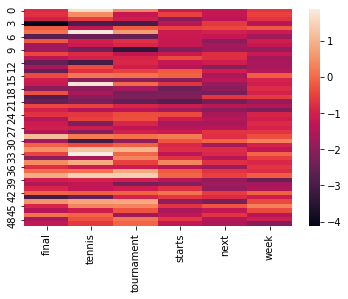

In [219]:
# Visualize a bi-gram filter's outputs
tokens = tokeniser.sequences_to_texts(X)[0].split(' ')
sns.heatmap(conv_outputs[1], xticklabels=tokens)